In [116]:
import pysam
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from genepeeks.common import utilities as util
import seaborn as sns

%matplotlib inline

In [2]:
DMD_ensembl = util.Mongo.get_collection_data('gene', wanted_db='prod', query={'_id': 'DMD'}, find_one=True, single_field='ensembl')
DMD_exons = util.get_nested_value(DMD_ensembl, ('is_primary', 'transcripts', 'is_primary', 'exons'))
# had to make local change in utilities 
DMD_exons_merged = util.merge_intervals(DMD_exons, min_dist=200, include_index=True)
exon_labels = ['Ex' + exon['index'] for exon in DMD_exons_merged]

Finished loading the gene collection from the genepeeks-prod database with a single entries with a query of {'_id': 'DMD'} after 0.27 sec


In [3]:
# DMD exon/gene coordinates and useful regions (coordinates taken from IGV b37 reference)
EXON46 = [31950197, 31950344]
EXON47 = [31947713, 31947862]
EXON48 = [31893308, 31893490]
EXON49 = [31854835, 31854939]
EXON50 = [31838092, 31838200]
EXON51 = [31792077, 31792309]
DMD = [31115794, 33357558]  # taken from ensembl GRCh37

# deletion of partial exons
EX48_50_PART = [31838130, 31893308]

# for consistency with exon labeling in Ensembl
exon_dict = {exon['index']: [exon['start'], exon['end']] for exon in DMD_exons_merged}
print exon_dict['1'][1] - exon_dict['1'][0]

2702


In [4]:
# workaround to force real time print output in notebooks
# see http://stackoverflow.com/questions/29772158/make-ipython-notebook-print-in-real-time
import sys
oldsysstdout = sys.stdout
class flushfile():
    def __init__(self, f):
        self.f = f
    def __getattr__(self,name): 
        return object.__getattribute__(self.f, name)
    def write(self, x):
        self.f.write(x)
        self.f.flush()
    def flush(self):
        self.f.flush()
sys.stdout = flushfile(sys.stdout)

## Starting Data

In [5]:
# get full dataset and also subsets based on gender, sequencer, etc
coverage_df = pd.read_csv('../exon_data/coverage_matrix.csv', header=1, index_col=0)
coverage_df.index.name = None
coverage_df.date_modified = pd.to_datetime(coverage_df.date_modified)
coverage_df_f = coverage_df[coverage_df.gender == 'F']
coverage_df_m = coverage_df[coverage_df.gender == 'M']
coverage_df_RMA = coverage_df[coverage_df.subject.str.contains('FRMR')]
coverage_df_M1 = coverage_df[coverage_df.sequencer == 'M1']
coverage_df_M1_f = coverage_df_f[coverage_df_f.sequencer == 'M1']
coverage_df_T1_f = coverage_df_f[coverage_df_f.sequencer == 'T1']
print coverage_df.shape
coverage_df.head()

(1266, 88)


,id,subject,specimen,sample,gender,sequencer,flow_cell_id,lane,bwa_version,date_modified,...,Ex70,Ex71,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79
1,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L001,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L001,0.7.15-r1140,1970-01-01 00:00:01.477955702,...,102,42,76,55,139,44,30,71,12,81
2,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L002,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L002,0.7.15-r1140,1970-01-01 00:00:01.477955702,...,85,60,77,38,121,40,52,71,14,67
3,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L003,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L003,0.7.15-r1140,1970-01-01 00:00:01.477955702,...,143,45,76,37,137,37,33,74,6,38
4,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L004,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L004,0.7.15-r1140,1970-01-01 00:00:01.477955702,...,152,32,96,51,117,29,32,79,9,56
5,MESB-0009-690N_ACGT.1.P1.1,MESB-0009-690N,MESB-0009-690N_ACGT_1,MESB-0009-690N_ACGT.1.P1.1,M,P1,NaN,NaN,0.7.10-r789,1970-01-01 00:00:01.465400971,...,36,22,48,64,64,36,44,10,1,6


In [6]:
# function for reshaping data frames so that exons are observations (rows) and subjects are variables (columns)
def reshape_df(df, include_stats=False, subject_droplist=None):
    df_nodate = df.drop('date_modified', axis=1)
    df_grouped = df_nodate.groupby(['subject']).sum()
    df_norm = df_grouped.div(df_grouped.sum(axis=1), axis=0)
    df_norm = df_norm.transpose().reset_index()
    df_norm.rename(columns={'index': 'Exon'}, inplace=True)

    if subject_droplist:
        for subject in subject_droplist:
            df_norm.drop(subject, axis=1, inplace=True)
    if include_stats:
        df_norm['Mean'] = df_norm.mean(axis=1)
        df_norm['SD'] = df_norm.std(axis=1)
    return df_norm

In [7]:
# use RMA samples for initial probability vector -- note that all RMA individuals used the M1 mixin panel
# this is only the females in RMA
print coverage_df_RMA.sequencer.unique()
RMA_norm = reshape_df(coverage_df_RMA, include_stats=True)
RMA_norm.head()
X_probs = np.array(RMA_norm.Mean)
print len(X_probs)
X_probs

78


array([ 0.04589008,  0.00181261,  0.0111598 ,  0.01918853,  0.01104113,
        0.0166613 ,  0.0166843 ,  0.01212952,  0.00371631,  0.01597643,
        0.01188   ,  0.00994347,  0.00875295,  0.00676731,  0.0183255 ,
        0.007394  ,  0.00961452,  0.00514529,  0.01048072,  0.02985736,
        0.01276754,  0.01643603,  0.01196839,  0.00946219,  0.02820376,
        0.01037773,  0.02059615,  0.0089391 ,  0.01577857,  0.00666614,
        0.009583  ,  0.00995351,  0.02010135,  0.00837557,  0.01176132,
        0.0112656 ,  0.01252437,  0.00844386,  0.01113459,  0.01235549,
        0.01049119,  0.0076502 ,  0.01632141,  0.01293299,  0.02815898,
        0.00908641,  0.0234396 ,  0.01244374,  0.0216019 ,  0.00885256,
        0.01000741,  0.00725296,  0.02025866,  0.00825177,  0.02257343,
        0.00719029,  0.00731126,  0.00843966,  0.01311383,  0.02040325,
        0.00818417,  0.01599219,  0.00793946,  0.01305769,  0.02064807,
        0.01183257,  0.01847446,  0.00963051,  0.01236458,  0.00

## Gibbs Sampling


The full gene product of DMD consists of 78 exons, each with its own copy number in each subject ($\mathbf{C} = \{c_1, c_2, ..., c_{78}\}$), where $c_i \in{1,2,3...}$ For this simple model, assume that the $c_i$ are distributed discrete uniformly with support $ z = \{1,2,3\}$. 

We also know "intensity" values across the exons $\mathbf{X}= \{x_1, x_2,..., x_{78}\}$, and we let $$\mathbf{P} = \dfrac{\mathbf{C}\mathbf{X}}{\sum_i c_ix_i} = \{p_1, p_2, ..., p_{78}\}$$ 

This generates probability values for the multinomial distribution from which we will sample the reads for a single simulated "sequencing run". When testing a real subject's data, we still use the known $\mathbf{X}$ but use data $Y$ from the subject.

Initialize the intensities $\mathbf{X}$ (see X_probs above). Initialize $c_i$ values based on basic prior distribution. Assume 5000 reads per sample/subject and initialize a single sequencing run $Y = \{y_1, y_2, ... y_{78}\}$. 

At each iteration $t$, sample $c_i^t$ from the posterior distribution
$$f_{C^t|Y, C_j^t}(c) = \dfrac{\Pi_j (p_j|c_i=c)^{y_j}}{\sum_c \Pi_j (p_j|c_i=c)^{y_j}} $$ 
where $$ C_j^t = \{ c_1^t,...c_{i-1}^t, c_{i+1}^{t-1}, ... c_{78}^{t-1} \}$$

Normally this expression would include the prior distribution over $c$ but it easily cancels out as the uniform. (This expression also does not include the multinomial constant). 

After setting $c_i^t$, sample new sequencing run $Y$. Alternatively, could sample new sequencing run $Y^t$ only once per iteration $t$. 

Implementation considerations: $\Pi_j (p_j|c_i=c)^{y_j}$ generates underflow in Python, but trying to use the log of the posterior distribution leads to 
$$  \sum y_j \log (p_j|c_i=c) - \log \sum \Pi_j (p_j|c_i=c)^{y_j}$$

Solution: Convert to log space and divide by the maximal likelihood to normalize (and keep values shrinking too close to 0):
$$ \dfrac{\exp\left(\sum y_j \log (p_j|c_i=c) - \max_c \sum y_j \log (p_j|c_i=c)\right)}{\sum_c \exp\left(\sum y_j \log (p_j|c_i=c) - \max_c \sum y_j \log (p_j|c_i=c)\right)}$$ 


In [126]:
def generate_gibbs_df(cnv_support, X_probs, data=None, cnv=None, total_reads=5000, iterations=10000, burn_in=1000):
    '''Performs Gibbs sampling given a support vector for CNVs, an intensity vector and subject data (optional)'''
    if not cnv:
        # generate initial guess for exon copy numbers using uniform prior distribution
        cnv = np.random.choice(cnv_support, size=len(X_probs)) 
    print cnv 
    normed_probs_first = np.multiply(cnv, X_probs) / np.sum(np.multiply(cnv, X_probs))
    if not data:
        data = np.random.multinomial(total_reads, normed_probs_first)
    gibbs_data = np.zeros((len(X_probs), iterations))
    
    likelihoods = np.zeros(iterations)
    for i in range(iterations):
        if (i+1) % (iterations / 20) == 0:
            print 'Finished {} iterations'.format(i)
        for exon in range(len(X_probs)):
            test = np.zeros(len(cnv_support))
            for value in cnv_support:
                cnv[exon] = value
                # get new normed probabilities given test value
                normed_probs_test = np.multiply(cnv, X_probs) / np.sum(np.multiply(cnv, X_probs)) 
                log_likelihood =  np.sum(np.multiply(np.log(normed_probs_test), data))
                test[value - 1] = log_likelihood
            test = test - np.max(test)
            sample_probs = np.exp(test)
            sample_probs = sample_probs / np.sum(sample_probs)
            new_cnv = np.random.choice(cnv_support, p = sample_probs)
            cnv[exon] = new_cnv
            gibbs_data[exon, i] = new_cnv
    
        likelihoods[i] = np.sum(np.multiply(np.log(np.multiply(cnv, X_probs) / np.sum(np.multiply(cnv, X_probs))), data))
    gibbs_data_results = np.zeros((len(X_probs), len(cnv_support)))
    # get proportions using burn-in of 1000 iterations 
    for index in range(len(X_probs)):
        gibbs_data_results[index] = np.bincount(gibbs_data[index][burn_in:].astype(np.int64), 
                                                minlength=len(cnv_support)+1)[1:]
    gibbs_data_results = gibbs_data_results / float(iterations - burn_in)
    
    gibbs_df = pd.DataFrame(gibbs_data_results, columns =['copy_{}'.format(cnv) for cnv in cnv_support]).reset_index()
    gibbs_df.rename(columns={'index': 'Exon'}, inplace=True)
    gibbs_df.Exon = gibbs_df.Exon + 1
    
    return gibbs_data, gibbs_data_results, likelihoods, gibbs_df

In [127]:
cnv_support = [1,2,3]
gibbs_data2, gibbs_data_results2, logliks, gibbs_df2 = generate_gibbs_df(cnv_support, X_probs, total_reads=5000, 
                                                                        iterations=10000)

[3 2 2 3 3 2 1 3 3 2 1 2 1 3 1 1 1 2 1 2 1 3 3 3 1 3 1 1 1 3 3 1 1 1 3 2 1
 2 1 1 2 1 1 2 1 2 2 3 2 1 2 3 1 2 2 3 1 3 3 1 3 3 1 3 1 3 3 1 1 2 1 3 3 2
 1 1 1 2]
Finished 499 iterations
Finished 999 iterations
Finished 1499 iterations
Finished 1999 iterations
Finished 2499 iterations
Finished 2999 iterations
Finished 3499 iterations
Finished 3999 iterations
Finished 4499 iterations
Finished 4999 iterations
Finished 5499 iterations
Finished 5999 iterations
Finished 6499 iterations
Finished 6999 iterations
Finished 7499 iterations
Finished 7999 iterations
Finished 8499 iterations
Finished 8999 iterations
Finished 9499 iterations
Finished 9999 iterations


In [125]:
gibbs_df2.head(10)

,Exon,copy_1,copy_2,copy_3
0,1,1.0,0.0,0.0
1,2,1.0,0.0,0.0
2,3,1.0,0.0,0.0
3,4,1.0,0.0,0.0
4,5,1.0,0.0,0.0
5,6,1.0,0.0,0.0
6,7,1.0,0.0,0.0
7,8,1.0,0.0,0.0
8,9,1.0,0.0,0.0
9,10,1.0,0.0,0.0


[-20552.25114066 -20545.22154291 -20550.78214684 -20548.1067413
 -20544.09917654 -20549.99529527 -20547.34934187 -20545.8873025
 -20545.93720042 -20545.26960207]


<function matplotlib.pyplot.show>

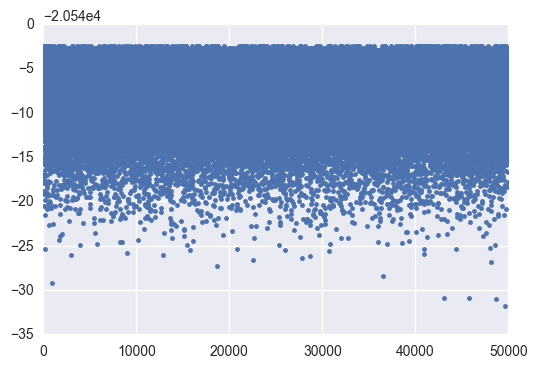

In [115]:
print logliks[:10]
# why don't likelihoods converge as iterations continue?
plt.figure()
plt.plot(range(len(logliks)), logliks, '.')
# plt.hist(logliks, bins=150)
plt.show

## Gibbs Sampling with simulated deletion data (with real subject template)